<a href="https://colab.research.google.com/github/yrrSelena/RUL/blob/master/RUL_LSTM_CMAPSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 载入库

In [2]:
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing

Using TensorFlow backend.


In [0]:
# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0


# 读取数据

## 设置常量参数

In [0]:
train_file = 'train_FD001.txt'
test_file = 'test_FD001.txt'
test_rul_file = 'RUL_FD001.txt'
n_ftrs = 26
n_units = 100
col_name = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
             's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
             's15', 's16', 's17', 's18', 's19', 's20', 's21']
#ftr_col_name = col_name[5:]

## 载入数据

In [0]:
# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv(train_file,names = col_name, header=None,delim_whitespace=True)
test_df = pd.read_csv(test_file,names = col_name, header=None,delim_whitespace=True)
rul_df = pd.read_csv(test_rul_file, names=['RUL'],header=None,delim_whitespace=True) 

# 数据预处理

## 训练数据

### 计算RUL

In [0]:
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index() #添加一列作为索引
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

### MinMax归一化处理

In [0]:
# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL'])

# 对数据进行min-max归一化处理[0,1]
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

### 特征筛选

In [9]:
t = train_df.max()==0
rebundant_ftr_name = t[t==True].index.tolist() #7个常量特征
selected_ftr_name = train_df.columns.difference(rebundant_ftr_name)
selected_ftr_name

Index(['RUL', 'cycle', 'cycle_norm', 'id', 's11', 's12', 's13', 's14', 's15',
       's17', 's2', 's20', 's21', 's3', 's4', 's6', 's7', 's8', 's9',
       'setting1', 'setting2'],
      dtype='object')

In [52]:
len(selected_ftr_name)

21

In [0]:
train_df =train_df.loc[:,selected_ftr_name]

## 测试数据

### MinMax归一化处理

In [0]:
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)

### 计算测试数据的RUL

In [0]:
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index() 
rul.columns = ['id', 'max']
rul_df.columns = ['more']
rul_df['id'] = rul_df.index + 1 # 获得每个发动机的编号
rul_df['max'] = rul['max'] + rul_df['more'] # 测试数据的生命周期=发动机的运行时间+剩余寿命
rul_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(rul_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)


In [46]:
test_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,cycle_norm,RUL
0,1,1,0.632184,0.750000,0.0,0.0,0.545181,0.310661,0.269413,0.0,1.0,0.652174,0.212121,0.127614,0.0,0.208333,0.646055,0.220588,0.132160,0.308965,0.0,0.333333,0.0,0.0,0.558140,0.661834,0.00000,142
1,1,2,0.344828,0.250000,0.0,0.0,0.150602,0.379551,0.222316,0.0,1.0,0.805153,0.166667,0.146684,0.0,0.386905,0.739872,0.264706,0.204768,0.213159,0.0,0.416667,0.0,0.0,0.682171,0.686827,0.00277,141
2,1,3,0.517241,0.583333,0.0,0.0,0.376506,0.346632,0.322248,0.0,1.0,0.685990,0.227273,0.158081,0.0,0.386905,0.699360,0.220588,0.155640,0.458638,0.0,0.416667,0.0,0.0,0.728682,0.721348,0.00554,140
3,1,4,0.741379,0.500000,0.0,0.0,0.370482,0.285154,0.408001,0.0,1.0,0.679549,0.196970,0.105717,0.0,0.255952,0.573561,0.250000,0.170090,0.257022,0.0,0.250000,0.0,0.0,0.666667,0.662110,0.00831,139
4,1,5,0.580460,0.500000,0.0,0.0,0.391566,0.352082,0.332039,0.0,1.0,0.694042,0.166667,0.102396,0.0,0.273810,0.737740,0.220588,0.152751,0.300885,0.0,0.166667,0.0,0.0,0.658915,0.716377,0.01108,138


In [0]:
test_df =test_df.loc[:,selected_ftr_name]

# 生成样本特征

In [0]:
sequence_length = 50 #设置时间窗口大小
sequence_cols = list(selected_ftr_name.difference(['RUL','cycle','id'])) #设置特征(18)

In [14]:
len(sequence_cols)

18

In [0]:
# pick a large window size of 50 cycles

# function to reshape features into (samples, time steps, features) 
# 生成特征样本
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones 
    只有比时间窗口大的序列会被提取特征，若测试样本的时间序列过小，则被忽视。
    另一种方法是对序列进行填充
    """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values # 获得对应列的值
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,142),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 141 191 -> from row 141 to 191
    
    # zip将数据打包为元组的列表
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :] #yield 相当于返回
        

In [57]:
# TODO for debug 
# 样例测试
# val is a list of 192 - 50 = 142 bi-dimensional array (50 rows x 18 columns)
val=list(gen_sequence(train_df[train_df['id']==1], sequence_length, sequence_cols))
print(len(val))

142


In [0]:
# 对每个发动机生成训练样本
# generator for the sequences
# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

In [17]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

(15631, 50, 18)


# 生成样本标签

In [0]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]] 
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previus ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]

In [19]:
# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(15631, 1)

# 构建深度网络

In [0]:
# define path to save model
model_path = 'LSTM_cmpass_model1.h5'

In [22]:
def r2_keras(y_true, y_pred):
    """Coefficient of Determination 
    """
    SS_res =  K.sum(K.square( y_true - y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

# Next, we build a deep network. 
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units. 
# Dropout is also applied after each LSTM layer to control overfitting. 
# 采用Dropout防止过拟合
# Final layer is a Dense output layer with single unit and linear activation since this is a regression problem.
# 由于此问题是回归问题，因此在最后采用单一神经元以及一个线性激活函数

nb_features = seq_array.shape[2] # 特征数目：25
nb_out = label_array.shape[1] # 输出大小：1

# 定义一个sequential模型（多个网络层线性堆叠而成）
model = Sequential()
# 向模型中加入layer
model.add(LSTM(
         input_shape=(sequence_length, nb_features),#第一层需要接收一个样本数据shape的参数
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2)) #增加一个Dropout
model.add(Dense(units=nb_out)) #密集模块
model.add(Activation("linear")) # 线性激活函数
# 编译模型，对model进行配置
model.compile(loss='mean_squared_error', optimizer='rmsprop',metrics=['mae',r2_keras])
# 采用MSE进行模型训练，采用rmsprop作为优化器，采用mae和自己定义的r2_keras进行性能评估

print(model.summary())

# fit the network
# 模型训练
history = model.fit(seq_array, label_array, epochs=50, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 100)           47600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
_________________________________________________________________
activation_1 (Activat

In [23]:
# fit the network
# 模型训练
history = model.fit(seq_array, label_array, epochs=50, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

Train on 14849 samples, validate on 782 samples
Epoch 1/50
 - 26s - loss: 606.9260 - mean_absolute_error: 15.5290 - r2_keras: 0.8144 - val_loss: 896.7807 - val_mean_absolute_error: 19.5974 - val_r2_keras: 0.4812
Epoch 2/50
 - 26s - loss: 597.1045 - mean_absolute_error: 15.3777 - r2_keras: 0.8171 - val_loss: 620.2856 - val_mean_absolute_error: 16.2761 - val_r2_keras: 0.7221
Epoch 3/50
 - 26s - loss: 587.6749 - mean_absolute_error: 15.1665 - r2_keras: 0.8213 - val_loss: 730.2551 - val_mean_absolute_error: 16.9858 - val_r2_keras: 0.6999
Epoch 4/50
 - 26s - loss: 574.6524 - mean_absolute_error: 15.0652 - r2_keras: 0.8238 - val_loss: 737.6172 - val_mean_absolute_error: 19.9982 - val_r2_keras: 0.6787
Epoch 5/50
 - 26s - loss: 564.1780 - mean_absolute_error: 14.9722 - r2_keras: 0.8275 - val_loss: 741.3241 - val_mean_absolute_error: 16.5970 - val_r2_keras: 0.6115
Epoch 6/50
 - 26s - loss: 553.3881 - mean_absolute_error: 14.7131 - r2_keras: 0.8305 - val_loss: 632.1895 - val_mean_absolute_error:

In [24]:
# list all data in history
print(history.history.keys())

dict_keys(['val_loss', 'val_mean_absolute_error', 'val_r2_keras', 'loss', 'mean_absolute_error', 'r2_keras'])


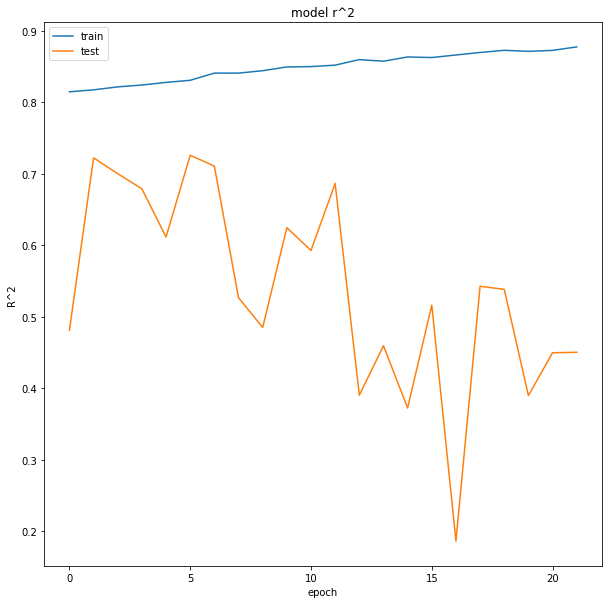

In [25]:
# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_r2.png")

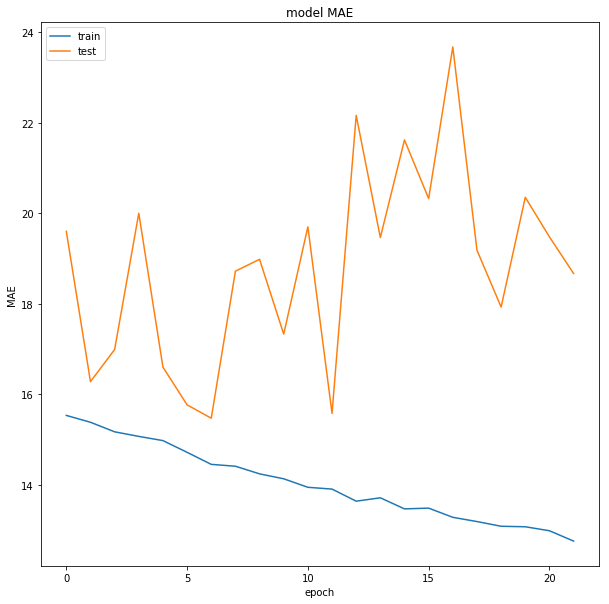

In [26]:
# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_mae.png")

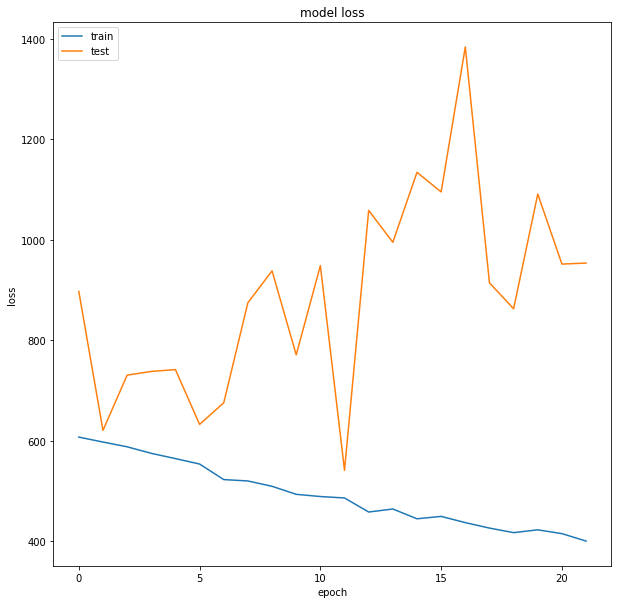

In [27]:
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_regression_loss.png")

In [28]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv('submit_train.csv', index = None)

15631/15631 [==============================] - 7s 480us/step

MAE: 12.075915369006115

R^2: 0.8509904890156214
15631/15631 [==============================] - 8s 495us/step


In [0]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

In [0]:
def RHS_score(y_pred, y_true):
  delta = y_pred-y_true
  s1 = np.exp(-delta[delta<0]/13)-1
  s2 = np.exp(delta[delta>=0]/10)-1
  rhs = (np.sum(s1)+np.sum(s2))/len(delta)
  return rhs

In [0]:
delta = y_pred-y_true

In [32]:
mse_valid = np.sum((y_pred - y_true)**2)/len(y_true)
rmse_valid = mse_valid**0.5
mae_valid = np.sum(np.absolute(y_pred - y_true))/len(y_true)
r2_valid = 1 - mse_valid/np.var(y_true)
rhs_valid = RHS_score(y_pred,y_true)
print('mse:',mse_valid)
print('rmse:',rmse_valid)
print('mae:',mae_valid)
print('r2:',r2_valid)
print('rhs:',rhs_valid)

mse: 377.39428059625106
rmse: 19.426638427588315
mae: 12.075915848314247
r2: 0.8844198311195588
rhs: 77.69869969931547


In [0]:
model.save(model_path)

In [35]:
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

15631/15631 [==============================] - 8s 480us/step

MAE: 12.075915369006115

R^2: 0.8509904890156214


In [0]:
y_pred.shape

(15631, 1)

In [0]:
# We pick the last sequence for each id in the test data
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
#print("seq_array_test_last")
#print(seq_array_test_last)
#print(seq_array_test_last.shape)

# Similarly, we pick the labels
#print("y_mask")
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
#print(label_array_test_last.shape)
#print("label_array_test_last")
#print(label_array_test_last)




MAE: 13.880435307820639

R^2: 0.7385698928627916


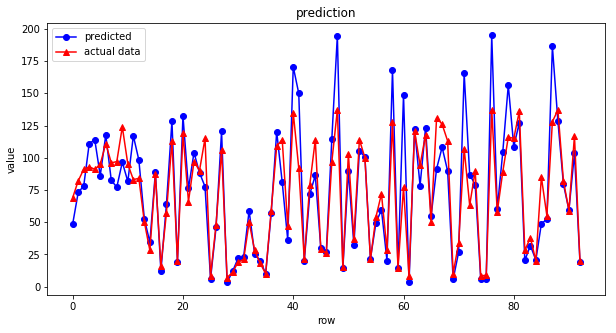

In [38]:
# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras}) # 加载模型

    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv('submit_test.csv', index = None)

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(10, 5))
    plt.plot(y_pred_test, 'b-o')
    plt.plot(y_true_test, 'r-^')
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    fig_verify.savefig("model_regression_verify.png")

In [39]:
mse_test = np.sum((y_pred_test - y_true_test)**2)/len(y_true_test)
rmse_test = mse_test**0.5
mae_test = np.sum(np.absolute(y_pred_test - y_true_test))/len(y_true_test)
r2_test = 1 - mse_test/np.var(y_true_test)
rhs_test = RHS_score(y_pred_test, y_true_test)
print('mse:',mse_test)
print('rmse:',rmse_test)
print('mae:',mae_test)
print('r2:',r2_test)
print('rhs_test:',rhs_test)


mse: 451.6507056451613
rmse: 21.252075325604352
mae: 13.880436722950268
r2: 0.7316982989646048
rhs_test: 35.72644436743952
